# How do I plot the results?
That is all too easy.
1. Load model parameters and metrics history.
2. Recreate the SET dataset. NOTE: It is crucial to save the seed and manipulations.
3. Use the function `generate_summary_plot`.

## Imports

In [7]:
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from src.task import SETDataset
from src.model import EulerCTRNNCell
from src.training import deserialize_parameters, load_metrics_from_csv
from src.analysis import generate_summary_plot

key = random.PRNGKey(0)

## Load model and metrics

In [2]:
features = 100
alpha = jnp.float32(1.0)
noise = jnp.float32(0.0)
x = jnp.ones((10, 50, features))
ctrnn = nn.RNN(EulerCTRNNCell(features=features, alpha=alpha, noise=noise,))
key, subkey = random.split(key)
params = ctrnn.init(subkey, x,)

In [3]:
save_loc = '../results/script_examples/params.bin'
params = deserialize_parameters(save_loc, params)

In [4]:
save_loc = '../results/script_examples/metrics_history.csv'
loaded_metrics = load_metrics_from_csv(save_loc)

## Recreate SET dataset

In [8]:
key = random.PRNGKey(0)
key, subkey = random.split(key)
set_dataset = SETDataset(subkey, 15, 5, 5, 108)
#set_dataset.grok_SET(2)
#set_dataset.corrupt_SET(3)
set_dataset.print_training_testing()
training_tf_dataset, testing_tf_dataset, grok_tf_dataset, corrupt_tf_dataset = set_dataset.tf_datasets()


TRAINING DATA

Accepting Grid:
SET_combinations | Number of Trials | Status
GGG | 30 | 
GPR | 30 | 
GRP | 30 | 
PGR | 30 | 
PPP | 30 | 
PRG | 30 | 
RGP | 30 | 
RPG | 30 | 
RRR | 30 | 

Rejecting Grid:
SET_combinations | Number of Trials | Status
GGP | 15 | 
GGR | 15 | 
GPG | 15 | 
GPP | 15 | 
GRG | 15 | 
GRR | 15 | 
PGG | 15 | 
PGP | 15 | 
PPG | 15 | 
PPR | 15 | 
PRP | 15 | 
PRR | 15 | 
RGG | 15 | 
RGR | 15 | 
RPP | 15 | 
RPR | 15 | 
RRG | 15 | 
RRP | 15 | 

----------

TESTING DATA

Accepting Grid:
SET_combinations | Number of Trials | Status
GGG | 5 | 
GPR | 5 | 
GRP | 5 | 
PGR | 5 | 
PPP | 5 | 
PRG | 5 | 
RGP | 5 | 
RPG | 5 | 
RRR | 5 | 

Rejecting Grid:
SET_combinations | Number of Trials | Status
GGP | 5 | 
GGR | 5 | 
GPG | 5 | 
GPP | 5 | 
GRG | 5 | 
GRR | 5 | 
PGG | 5 | 
PGP | 5 | 
PPG | 5 | 
PPR | 5 | 
PRP | 5 | 
PRR | 5 | 
RGG | 5 | 
RGR | 5 | 
RPP | 5 | 
RPR | 5 | 
RRG | 5 | 
RRP | 5 | 

----------

GROK DATA

Accepting Grid:
SET_combinations | Number of Trials | Status

Reje

## Generate summary plot

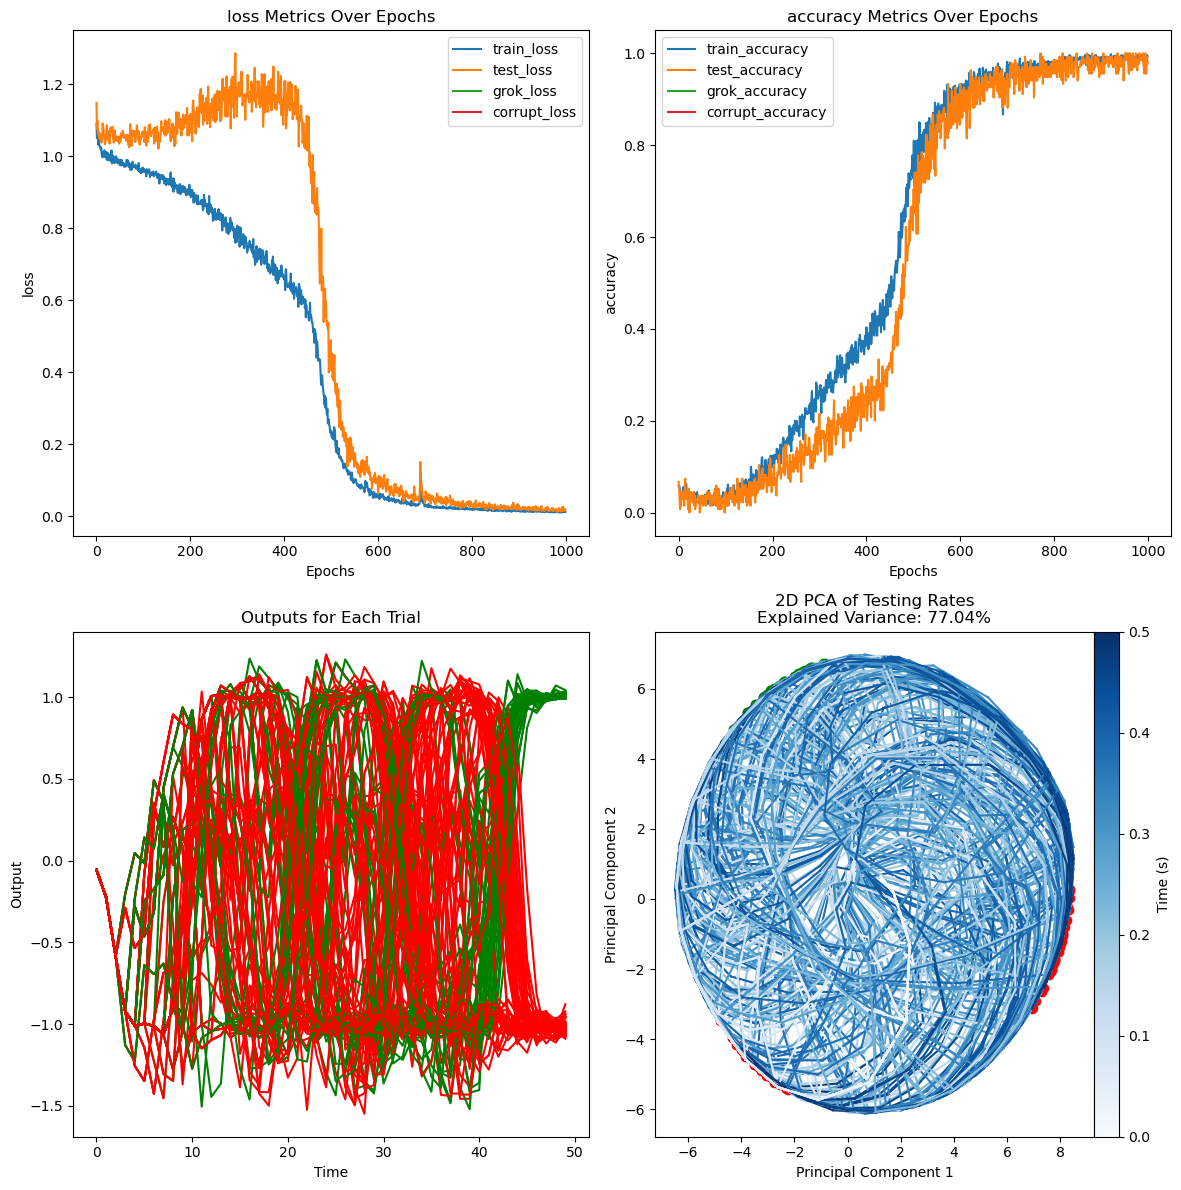

In [6]:
save_loc = '../results/script_examples/summary_plot.jpg'
key, subkey = random.split(key)
generate_summary_plot(subkey, ctrnn, params, loaded_metrics, training_tf_dataset, testing_tf_dataset, save_loc)